<a href="https://colab.research.google.com/github/NirmitGavate/ISIC-experiments/blob/main/ISIC_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Contains functions for training and testing a PyTorch model.
"""
import torch
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, confusion_matrix

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float, List[int], List[int], List[List[float]], torch.Tensor, List[str]]:
    model.train()
    train_loss, train_acc = 0, 0
    all_preds = []
    all_labels = []
    all_probs = []
    all_md = []
    all_ids = []

    for batch, (id, X, y, md) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        probs = torch.softmax(y_pred, dim=1)
        preds = torch.argmax(probs, dim=1)
        train_acc += (preds == y).sum().item() / len(y)

        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(y.cpu().tolist())
        all_probs.extend(probs.cpu().tolist())
        all_md.append(md)
        all_ids.extend(id)

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    all_md_tensor = torch.cat(all_md, dim=0).cpu()

    return train_loss, train_acc, all_preds, all_labels, all_probs, all_md_tensor, all_ids


def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float, Dict[str, float], List[List[int]],
                                             List[int], List[int], List[List[float]], torch.Tensor, List[str]]:
    model.eval()
    test_loss, test_acc = 0, 0
    all_preds = []
    all_labels = []
    all_probs = []
    all_md = []
    all_ids = []

    with torch.inference_mode():
        for batch, (id, X, y, md) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            logits = model(X)
            loss = loss_fn(logits, y)
            test_loss += loss.item()

            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)
            test_acc += (preds == y).sum().item() / len(y)

            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(y.cpu().tolist())
            all_probs.extend(probs.cpu().tolist())
            all_md.append(md)
            all_ids.extend(id)

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average=None, zero_division=0)

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    auc = roc_auc_score(all_labels, all_probs[:, 1])
    conf_mat = confusion_matrix(all_labels, all_preds)

    metrics_dict = {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "auc_roc": auc
    }

    all_md_tensor = torch.cat(all_md, dim=0).cpu()

    return (test_loss, test_acc, metrics_dict, conf_mat.tolist(),
            all_preds.tolist(), all_labels.tolist(), all_probs.tolist(), all_md_tensor, all_ids)


def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          scheduler: torch.optim.Optimizer,
          epochs: int,
          device: torch.device) -> Tuple[Dict[str, List], Dict[str, float], Dict, Dict]:

    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
        "precision": [],
        "recall": [],
        "f1": [],
        "auc_roc": [],
        "conf_matrix": []
    }

    # initialize dicts to store only the last epoch's info
    full_train_info = {"labels": [], "preds": [], "probs": None, "metadata": None, "ids": []}
    full_test_info = {"labels": [], "preds": [], "probs": None, "metadata": None, "ids": []}

    model.to(device)

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc, train_preds, train_labels, train_probs, train_md, train_ids = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device)

        test_loss, test_acc, metrics_dict, conf_matrix, test_preds, test_labels, test_probs, test_md, test_ids = test_step(
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            device=device)

        # scheduler.step(test_loss)  # optional

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | test_acc: {test_acc:.4f}"
        )
        print("Precision per class:", metrics_dict["precision"])
        print("Recall per class:   ", metrics_dict["recall"])
        print("F1-score per class: ", metrics_dict["f1"])
        print("AUC-ROC (ovr):      ", metrics_dict["auc_roc"])
        print("Confusion Matrix:\n", conf_matrix)

        # Store metrics per epoch
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        results["precision"].append(metrics_dict["precision"].tolist())
        results["recall"].append(metrics_dict["recall"].tolist())
        results["f1"].append(metrics_dict["f1"].tolist())
        results["auc_roc"].append(metrics_dict["auc_roc"])
        results["conf_matrix"].append(conf_matrix)

        # Save only the last epoch's metadata/probs
        if epoch == epochs - 1:
            full_train_info["labels"] = train_labels
            full_train_info["preds"] = train_preds
            full_train_info["probs"] = np.array(train_probs)
            full_train_info["metadata"] = train_md.cpu().numpy()
            full_train_info["ids"] = train_ids

            full_test_info["labels"] = test_labels
            full_test_info["preds"] = test_preds
            full_test_info["probs"] = np.array(test_probs)
            full_test_info["metadata"] = test_md.cpu().numpy()
            full_test_info["ids"] = test_ids

    return results, metrics_dict, full_train_info, full_test_info

In [ ]:
!pip install -q torchinfo optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 22.8 MB/s eta 0:00:00


# IMPORTS

In [ ]:
import os
import io
import random
import requests
import h5py
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
from tqdm.auto import tqdm

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision
from torchvision import transforms
from torchinfo import summary

from sklearn.model_selection import (
    train_test_split, GroupKFold, cross_val_score
)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, OneHotEncoder,OrdinalEncoder
)
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import make_column_selector as selector

from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, confusion_matrix
import kagglehub
from google.colab import files
import optuna
from sklearn.metrics import confusion_matrix
from lightgbm import LGBMClassifier

In [ ]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [ ]:
# !git clone https://github.com/mrdbourke/pytorch-deep-learning
# !mv pytorch-deep-learning/going_modular .
# !rm -rf pytorch-deep-learning

In [ ]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nirmitgavate1","key":"1ee654377f2a3c2587302cb05da4662a"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c isic-2024-challenge

100% 1.99G/2.00G [00:27<00:00, 172MB/s]
100% 2.00G/2.00G [00:27<00:00, 77.7MB/s]


In [ ]:
!unzip -q isic-2024-challenge.zip -d isic-data

# metadata

In [ ]:
train_df=pd.read_csv("isic-data/train-metadata.csv")

/tmp/ipython-input-11-3357258532.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df=pd.read_csv("isic-data/train-metadata.csv")


#UNDERSAMPLING AND OVERSAMPLING

In [ ]:
len(train_df[train_df['target']==0].sample(frac=0.003,random_state=42))

1202

In [ ]:
print("Distribution before sampling")
(train_df['target'].value_counts()/len(train_df))*100,train_df['target'].value_counts()

Distribution before sampling


(target
 0    99.902009
 1     0.097991
 Name: count, dtype: float64,
 target
 0    400666
 1       393
 Name: count, dtype: int64)

In [ ]:
train_df=train_df.drop(['iddx_1','iddx_full','image_type'],axis=1)

In [ ]:
benign=train_df[train_df['target']==0].sample(frac=0.003,random_state=42)
malignant=train_df[train_df['target']==1].sample(frac=1.0,random_state=42)

In [ ]:
train_df=pd.concat([benign,malignant])

In [ ]:
print("Distribution after sampling")
(train_df['target'].value_counts()/len(train_df))*100,train_df['target'].value_counts()

Distribution after sampling


(target
 0    75.360502
 1    24.639498
 Name: count, dtype: float64,
 target
 0    1202
 1     393
 Name: count, dtype: int64)

In [ ]:
null_percentage_series=(train_df.isnull().sum()/len(train_df))*100

cols_to_keep=null_percentage_series[~(null_percentage_series>60)].index
train_df=train_df[cols_to_keep]

numeric_cols=list(train_df.drop("target",axis=1).select_dtypes(exclude="object").columns)
object_cols=list(train_df.select_dtypes(include="object").columns)

In [ ]:
#fill nulls and preprocessing
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, numeric_cols),
    ('cat', categorical_pipeline, object_cols)
])

In [ ]:
X=train_df.drop("target",axis=1)
y=train_df['target']

In [ ]:
weight_per_class=compute_class_weight(class_weight="balanced",classes=np.unique(y),y=y)
weights_to_idx={v:k for v,k in enumerate(weight_per_class)}
weights_to_idx,weight_per_class

({0: np.float64(0.663477537437604), 1: np.float64(2.0292620865139948)},
 array([0.66347754, 2.02926209]))

In [ ]:
from sklearn.model_selection import StratifiedGroupKFold

sgkf = StratifiedGroupKFold(n_splits=2, shuffle=True, random_state=42)

X = train_df[X.columns]
y = train_df['target']
groups = train_df['patient_id']

for train_idx, val_idx in sgkf.split(X, y, groups):
    train_df_split = train_df.iloc[train_idx].reset_index(drop=True)
    val_df_split = train_df.iloc[val_idx].reset_index(drop=True)
    break

X_train_table = train_df_split[X.columns]
X_valid_table = val_df_split[X.columns]
y_train_table = train_df_split['target']
y_valid_table = val_df_split['target']

X_train_table_preprocessed=preprocessor.fit_transform(X_train_table)
X_valid_table_preprocessed=preprocessor.transform(X_valid_table)

In [ ]:
preprocessor_feature_names = preprocessor.get_feature_names_out()

In [ ]:
sample_df=pd.DataFrame(X_train_table_preprocessed, columns=preprocessor_feature_names)
sample_df['target']=y_train_table.values
metadata_corr=sample_df.corr()['target'].sort_values(ascending=False)

In [ ]:
train_ids=train_df.iloc[train_idx]['isic_id'].values
val_ids=train_df.iloc[val_idx]['isic_id'].values

In [ ]:
preprocessed_train_data=[]
preprocessed_valid_data=[]
for id,data in zip(train_ids,X_train_table_preprocessed):
  preprocessed_train_data.append((data,id))
for id,data in zip(val_ids,X_valid_table_preprocessed):
  preprocessed_valid_data.append((data,id))

In [ ]:
preprocessed_data=preprocessed_train_data+preprocessed_valid_data

In [ ]:
label_dict={0: 'benign', 1: 'malignant'}

In [ ]:
# with h5py.File("isic-data/train-image.hdf5","r") as f:
#   train_isic_ids=list(f.keys())
with h5py.File("isic-data/test-image.hdf5","r") as f:
  test_isic_ids=list(f.keys())

In [ ]:
train_isic_ids=np.array(train_df.reset_index()['isic_id'].unique())

# Train Images

In [ ]:
train_df=train_df.set_index("isic_id")

In [ ]:
# fig,ax=plt.subplots(1,3,figsize=(12,6))
# ax=ax.flatten()
# for i in range(3):
#   id=np.random.choice(train_isic_ids)
#   label=train_df.loc[id]['target']
#   with h5py.File("isic-data/train-image.hdf5",'r') as f:
#     byte=f[id][()]
#   stream=io.BytesIO(byte)
#   img=Image.open(stream)
#   ax[i].imshow(img)
#   ax[i].set_title(f"{id}|{img.size} \n label:{label_dict[label]}",fontsize=8)
#   ax[i].axis(False)
# plt.subplots_adjust(wspace=0.5)
# plt.show()

# Test Images

In [ ]:
# fig,ax=plt.subplots(1,3,figsize=(12,6))
# ax=ax.flatten()
# for i in range(3):
#   id=np.random.choice(test_isic_ids)
#   with h5py.File("isic-data/test-image.hdf5",'r') as f:
#     byte=f[id][()]
#   stream=io.BytesIO(byte)
#   img=Image.open(stream)
#   ax[i].imshow(img)
#   ax[i].set_title(f"{id}|{img.size}",fontsize=8)
#   ax[i].axis(False)
# plt.subplots_adjust(wspace=0.5)
# # plt.suptitle("Test Image")
# plt.show()

In [ ]:
# custom_transform=transforms.Compose([
#     transforms.Resize(size=(128,128)),
#     transforms.TrivialAugmentWide(num_magnitude_bins=31)
# ])

In [ ]:
# id=np.random.choice(train_isic_ids)
# with h5py.File("isic-data/train-image.hdf5",'r') as f:
#   byte=f[id][()]
# streamer=io.BytesIO(byte)
# plt.subplot(1,2,1)
# img=Image.open(streamer)
# plt.imshow(img)
# plt.title(f"original image | {img.size}",fontsize=8)
# plt.axis(False)
# plt.subplot(1,2,2)
# ti=custom_transform(img)
# # print(ti.shape)
# # plt.title("transformed image")
# plt.title(f"transformed image | {ti.size}",fontsize=8)
# plt.imshow(ti)
# plt.axis(False)
# plt.show()

In [ ]:
benign_isic_ids=np.array(train_df[train_df['target']==0].index)
malignant_isic_ids=np.array(train_df[train_df['target']==1].index)

# Loading weights for pretrained model

In [ ]:
weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT
preprocess = weights.transforms()

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
augmented_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(p=0.5),  # Light, safe spatial augmentation
    # transforms.TrivialAugmentWide(31),
    transforms.CenterCrop(224),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),  # Mild color variation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Custom Dataset Class

In [ ]:
# class CustomIsicImageDataset(Dataset):
#     def __init__(self, dir_path, metadata_df, augmented_transform=None, transform=None):
#         self.dir_path = dir_path
#         self.metadata_df = metadata_df
#         self.transform = transform
#         self.augmented_transform = augmented_transform
#         self.id_list = sorted(metadata_df['isic_id'].astype(str).unique().tolist())
#         self.hdf5_file = h5py.File(self.dir_path, 'r')
#         self._cached_data = []

#         for id in self.id_list:
#             byte = self.hdf5_file[id][()]
#             stream = io.BytesIO(byte)
#             img = Image.open(stream).convert("RGB")
#             label = torch.tensor(
#                 self.metadata_df[self.metadata_df['isic_id'] == id]['target'].values[0]
#             ).long()

#             if label == 1:
#                 if self.augmented_transform:
#                     img_tensor = self.augmented_transform(img)
#                 else:
#                     img_tensor = self.transform(img) if self.transform else torchvision.transforms.ToTensor()(img)
#             else:
#                 img_tensor = self.transform(img) if self.transform else torchvision.transforms.ToTensor()(img)

#             self._cached_data.append((img_tensor, label))

#     def __len__(self):
#         return len(self._cached_data)

#     def __getitem__(self, index):
#         return self._cached_data[index]

In [ ]:
class CustomIsicDataset(Dataset):
    def __init__(self, dir_path, metadata_df,preprocessed_data,transform=None):
        self.dir_path = dir_path
        self.metadata_df = metadata_df
        self.transform = transform
        self.id_list =  sorted(metadata_df['isic_id'].astype(str).unique().tolist())
        self.hdf5_file = h5py.File(self.dir_path, 'r')
        self._cached_data = []
        self.preprocessed_data=preprocessed_data
        self.preprocessed_dict={id:data for (data,id) in self.preprocessed_data}

        for id in self.id_list:
            byte = self.hdf5_file[id][()]
            stream = io.BytesIO(byte)
            img = Image.open(stream).convert("RGB")
            img_tensor = self.transform(img) if self.transform else torchvision.transforms.ToTensor()(img)
            label = torch.tensor(self.metadata_df[self.metadata_df['isic_id'] == id]['target'].values[0]).long()
            table_data=torch.tensor(self.preprocessed_dict.get(id),dtype=torch.float32)
            self._cached_data.append((id,img_tensor, label,table_data))

    def __len__(self):
        return len(self._cached_data)

    def __getitem__(self, index):
        return self._cached_data[index]

# Dataset

In [ ]:
train_full_dataset=CustomIsicDataset("isic-data/train-image.hdf5", train_df_split, preprocessed_data,preprocess)
val_full_dataset=CustomIsicDataset("isic-data/train-image.hdf5", val_df_split, preprocessed_data,preprocess)

In [ ]:
# train_dataset = CustomIsicImageDataset("isic-data/train-image.hdf5", train_df_split, transform=preprocess)
# val_dataset = CustomIsicImageDataset("isic-data/train-image.hdf5", val_df_split, transform=preprocess)

# DataLoader

In [ ]:
from torch.utils.data import DataLoader, WeightedRandomSampler

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Weighted sampler (replace 'y_train' with your actual label list or tensor)
class_counts = np.bincount(y_train_table)
class_weights = 1. / class_counts
sample_weights = [class_weights[label] for label in y_train_table]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

train_dataloader = DataLoader(train_full_dataset, batch_size=32, sampler=sampler, num_workers=os.cpu_count())
val_dataloader = DataLoader(val_full_dataset, batch_size=32, shuffle=False, num_workers=os.cpu_count())

# pretrained model

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model=torchvision.models.efficientnet_b0(weights=weights).to(device) #new weights

In [ ]:
for param in model.parameters():
  param.requires_grad=False

# model.fc=torch.nn.Identity()
model.classifier= nn.Sequential(
  nn.Dropout(p=0.2, inplace=True),
  nn.Linear(in_features=1280, out_features=2, bias=True)
)

In [ ]:
weight_per_class_tensor=torch.tensor(weight_per_class,device=device,dtype=torch.float32)

In [ ]:
loss_fn=torch.nn.CrossEntropyLoss(weight=weight_per_class_tensor)
optimizer=torch.optim.Adam(lr=0.001,params=model.parameters(), weight_decay=1e-4)
scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
results, metrics_dict, full_train_info, full_test_info=train(model=model,
             train_dataloader=train_dataloader,
             test_dataloader=val_dataloader,
             optimizer=optimizer,
             scheduler=scheduler,
             loss_fn=loss_fn,
             epochs=50,
             device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6080 | train_acc: 0.6963 | test_loss: 0.6435 | test_acc: 0.5873
Precision per class: [0.83550914 0.34975369]
Recall per class:    [0.54794521 0.69268293]
F1-score per class:  [0.66184074 0.46481178]
AUC-ROC (ovr):       0.679143000334113
Confusion Matrix:
 [[320, 264], [63, 142]]
Epoch: 2 | train_loss: 0.5506 | train_acc: 0.7648 | test_loss: 0.5541 | test_acc: 0.7286
Precision per class: [0.8788501  0.48344371]
Recall per class:    [0.73287671 0.71219512]
F1-score per class:  [0.79925303 0.57593688]
AUC-ROC (ovr):       0.7927831607083194
Confusion Matrix:
 [[428, 156], [59, 146]]
Epoch: 3 | train_loss: 0.5030 | train_acc: 0.7716 | test_loss: 0.5621 | test_acc: 0.7636
Precision per class: [0.86288848 0.53719008]
Recall per class:    [0.80821918 0.63414634]
F1-score per class:  [0.83465959 0.58165548]
AUC-ROC (ovr):       0.7883812228533243
Confusion Matrix:
 [[472, 112], [75, 130]]
Epoch: 4 | train_loss: 0.4468 | train_acc: 0.8389 | test_loss: 0.5511 | test_acc

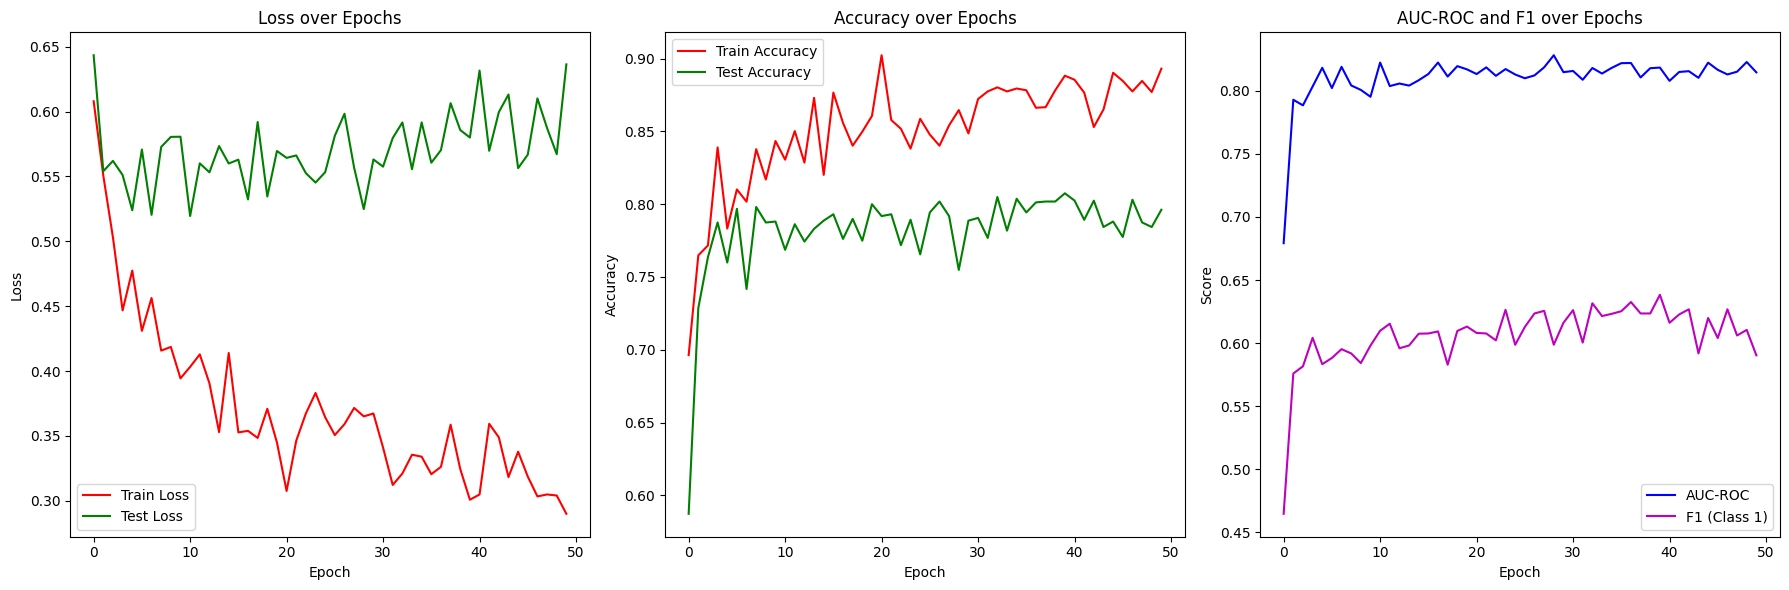

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18,6))

# Loss curves
plt.subplot(1,3,1)
plt.plot(results['train_loss'], c='r', label="Train Loss")
plt.plot(results['test_loss'], c='g', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

# Accuracy curves
plt.subplot(1,3,2)
plt.plot(results['train_acc'], c='r', label="Train Accuracy")
plt.plot(results['test_acc'], c='g', label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

# AUC and F1 curves
plt.subplot(1,3,3)
plt.plot(results['auc_roc'], c='b', label="AUC-ROC")
f1_class1 = [f[1] for f in results['f1']]

plt.plot(f1_class1, c='m', label="F1 (Class 1)")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("AUC-ROC and F1 over Epochs")
plt.legend()

plt.tight_layout()
plt.show()


# IMAGE ONLY RESULTS

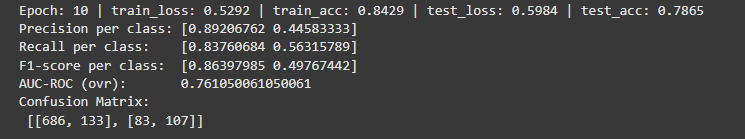

In [ ]:
# ---------- Train ----------
labels = full_train_info["labels"]
metadata = full_train_info["metadata"]
ids = full_train_info["ids"]
probs = full_train_info["probs"]  # shape: (N, 2)

# Create column names for metadata
num_features = metadata.shape[1]
metadata_cols = [f"meta_{i}" for i in range(num_features)]

# Build the DataFrame
df_train = pd.DataFrame(metadata, columns=metadata_cols)
df_train["label"] = labels
# df_train["id"] = ids
df_train["prob_class_0"] = probs[:, 0]
df_train["prob_class_1"] = probs[:, 1]

# ---------- Validation/Test ----------
val_labels = full_test_info["labels"]
val_metadata = full_test_info["metadata"]
val_ids = full_test_info["ids"]
val_probs = full_test_info["probs"]  # shape: (N, 2)

# Create column names for metadata
num_val_features = val_metadata.shape[1]
val_metadata_cols = [f"meta_{i}" for i in range(num_val_features)]

# Build the DataFrame
df_val = pd.DataFrame(val_metadata, columns=val_metadata_cols)
df_val["label"] = val_labels
# df_val["id"] = val_ids
df_val["prob_class_0"] = val_probs[:, 0]
df_val["prob_class_1"] = val_probs[:, 1]


In [ ]:
df_train.to_numpy().max(),df_train.to_numpy().min()

(np.float64(805.0), np.float64(-6.538323879241943))

In [ ]:
X_train=df_train.drop("label",axis=1)
X_val=df_val.drop("label",axis=1)
y_train=df_train['label']
y_val=df_val['label']

# getting data ready for ML Models

In [ ]:
train_df=train_df.reset_index()

In [ ]:
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
import numpy as np
import time
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score
import numpy as np
import time

def get_model_report(model_name, scaler, X_train, y_train, X_test, y_test, seed=42):
    # Scale data
    scaled_X_train = scaler.fit_transform(X_train)
    scaled_X_test = scaler.transform(X_test)

    # Initialize model
    model = model_name(random_state=seed, class_weight='balanced')

    # Measure training time
    start_train = time.time()
    model.fit(scaled_X_train, y_train)
    train_time = time.time() - start_train

    # Measure inference time
    start_infer = time.time()
    pred = model.predict(scaled_X_test)
    infer_time = time.time() - start_infer

    # Get probabilities or decision function
    try:
        pred_proba = model.predict_proba(scaled_X_test)[:, 1]
    except AttributeError:
        try:
            pred_proba = model.decision_function(scaled_X_test)
        except AttributeError:
            pred_proba = None

    # Compute AUC if possible
    if pred_proba is not None:
        auc_score = roc_auc_score(y_test, pred_proba)
    else:
        auc_score = "N/A (no proba/decision_function)"

    # Classification report and cross-validation
    report = classification_report(y_test, pred)
    # cv = cross_val_score(model, scaled_X_train, y_train, cv=5, scoring='f1_macro')
    # cv = np.round(cv.mean(), 2)

    print(f'Train Time:{train_time:.4f} | Inference Time:{infer_time:.4f} | AUC: {auc_score}')

    return report, model.__class__.__name__, pred

# RandomForestClassifier

In [ ]:
rfc_rep,rfc,rfc_pred=get_model_report(RandomForestClassifier,StandardScaler(),X_train, y_train, X_val, y_val)
print(rfc_rep)

Train Time:0.2978 | Inference Time:0.0110 | AUC: 0.9157367190110257
              precision    recall  f1-score   support

           0       0.84      0.97      0.90       584
           1       0.85      0.48      0.61       205

    accuracy                           0.84       789
   macro avg       0.84      0.73      0.76       789
weighted avg       0.84      0.84      0.83       789



# LGBMClassifier

In [ ]:
lgbm_rep,lgbm,lgbm_pred=get_model_report(LGBMClassifier,StandardScaler(),X_train, y_train, X_val, y_val)
print(lgbm_rep)

[LightGBM] [Info] Number of positive: 168, number of negative: 638
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9143
[LightGBM] [Info] Number of data points in the train set: 806, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Train Time:0.3120 | Inference Time:0.0086 | AUC: 0.9262445706648847
              precision    recall  f1-score   support

           0       0.89      0.96      0.92       584
           1       0.84      0.66      0.74       205

    accuracy                           0.88       789
   macro avg       0.86      0.81      0.83       789
weighted avg       0.88      0.88      0.87       789



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


# support vector classifier

In [ ]:
svc_rep,svc,svc_pred=get_model_report(SVC,StandardScaler(),X_train, y_train, X_val, y_val)
print(svc_rep)

Train Time:0.0169 | Inference Time:0.0260 | AUC: 0.911602071500167
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       584
           1       0.77      0.66      0.71       205

    accuracy                           0.86       789
   macro avg       0.83      0.80      0.81       789
weighted avg       0.86      0.86      0.86       789



# LogisticRegression

In [ ]:
logr_rep,logr,logr_pred=get_model_report(LogisticRegression,StandardScaler(),X_train, y_train, X_val, y_val)
print(logr_rep)

Train Time:0.0104 | Inference Time:0.0004 | AUC: 0.8719345138656865
              precision    recall  f1-score   support

           0       0.90      0.83      0.87       584
           1       0.61      0.75      0.67       205

    accuracy                           0.81       789
   macro avg       0.76      0.79      0.77       789
weighted avg       0.83      0.81      0.81       789



# CONFUSION MATRIX

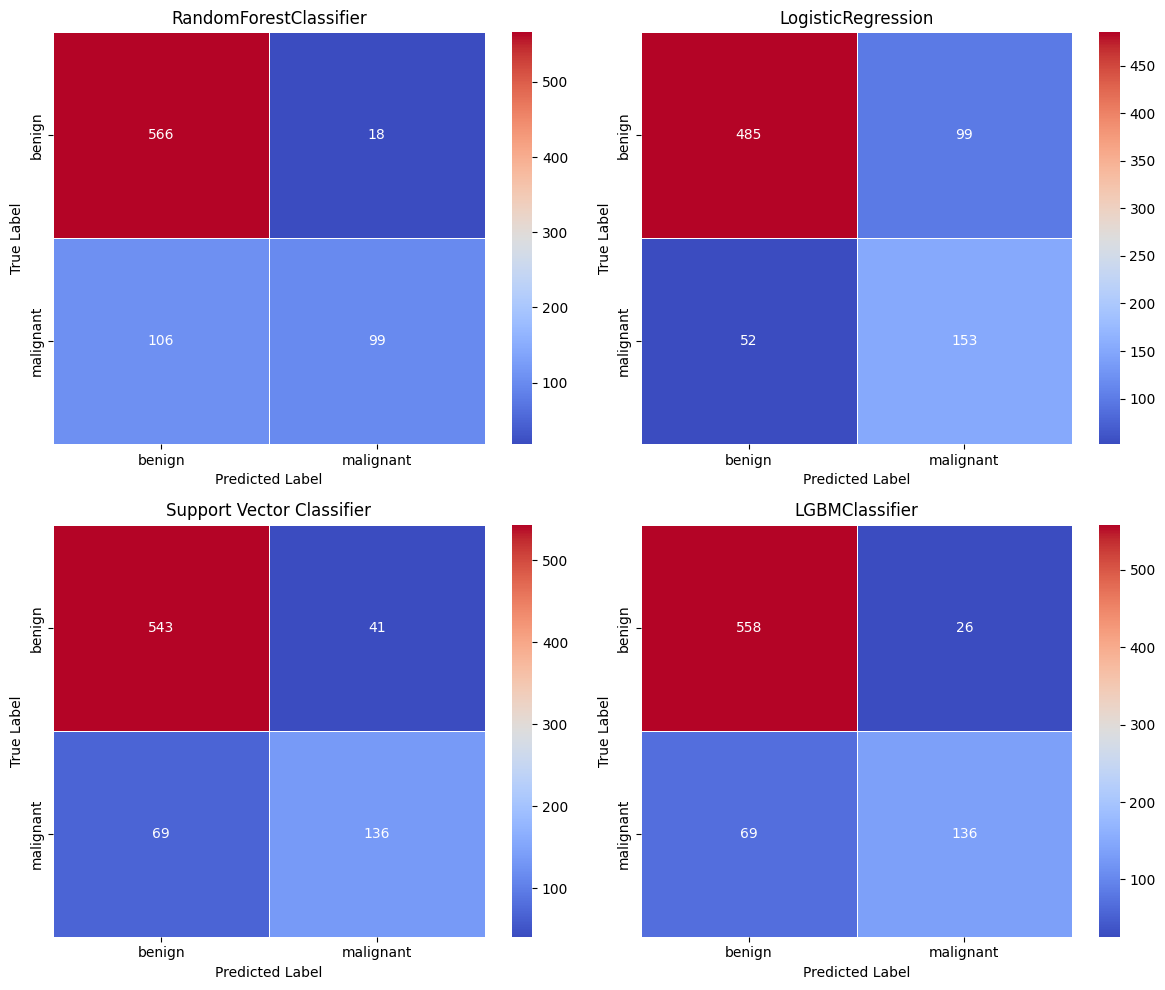

In [ ]:
label_names = list(label_dict.values())
label_names
def get_conf_matrix(predictions, model_name, i):
    cm = confusion_matrix(y_val, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', linewidths=.5, ax=ax[i],xticklabels=label_names, yticklabels=label_names)

    ax[i].set_title(model_name)
    ax[i].set_xlabel('Predicted Label')
    ax[i].set_ylabel('True Label')


fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax = ax.flatten()

get_conf_matrix(rfc_pred, "RandomForestClassifier", 0)
get_conf_matrix(logr_pred, "LogisticRegression", 1)
get_conf_matrix(svc_pred, "Support Vector Classifier", 2)
get_conf_matrix(lgbm_pred, "LGBMClassifier", 3)

plt.tight_layout()
plt.show()

In [ ]:
metrics_dict

{'precision': array([0.85191348, 0.61702128]),
 'recall': array([0.87671233, 0.56585366]),
 'f1': array([0.86413502, 0.59033079]),
 'auc_roc': np.float64(0.8144921483461409)}